In [1]:
from netCDF4 import Dataset

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
fileName = '../../ETOPO1_Ice_g_gmt4.grd'

fh = Dataset(fileName, mode='r')

fh.variables.keys()

x = fh.variables['x']
y = fh.variables['y']
z = fh.variables['z']

In [3]:
k = 10
x0 = x[::k]
y0 = y[::k]
z0 = z[::k,::k]

In [4]:
75.023, -23.564, 134.96, 23.725

(75.023, -23.564, 134.96, 23.725)

In [5]:
i0 = np.argmin(np.abs(x0+180))
i1 = np.argmin(np.abs(x0-180))
j0 = np.argmin(np.abs(y0+80))
j1 = np.argmin(np.abs(y0-80))

In [6]:
x1 = x0[i0:i1]
y1 = y0[j0:j1]
z1 = z0[j0:j1,i0:i1]

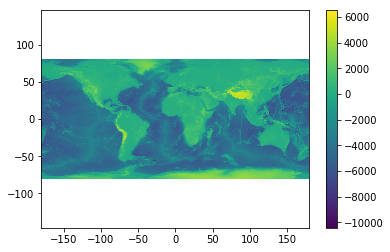

In [7]:
plt.pcolormesh(x1,y1,z1)
plt.axis('equal')
plt.colorbar()

In [8]:
np.savetxt('bathymetry', -z1)

In [9]:
x1.min(),x1.max()

(-180.0, 179.83333333333331)

In [10]:
y1.min(),y1.max()

(-79.99999999999997, 79.83333333333336)

In [11]:
x1.shape,y1.shape,z1.shape

((2160,), (960,), (960, 2160))

In [12]:
from scipy.misc import toimage

In [13]:
im = toimage(-z1)

c:\users\jose\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  """Entry point for launching an IPython kernel.


In [14]:
im.save('bathymetry.png')

In [15]:
z1.min(),z1.max()

(-10421, 6527)

# Slabs

In [16]:
from os import listdir
from os.path import isfile, join

In [17]:
root = '../../allslabs/'
files = [join(root,f[:-9]) for f in listdir(root) if isfile(join(root,f)) and f[-9:] == '_clip.grd']
files

['../../allslabs/alu_slab1.0',
 '../../allslabs/cas_slab1.0',
 '../../allslabs/izu_slab1.0',
 '../../allslabs/ker_slab1.0',
 '../../allslabs/kur_slab1.0',
 '../../allslabs/mex_slab1.0',
 '../../allslabs/phi_slab1.0',
 '../../allslabs/ryu_slab1.0',
 '../../allslabs/sam_slab1.0',
 '../../allslabs/sco_slab1.0',
 '../../allslabs/sol_slab1.0',
 '../../allslabs/sum_slab1.0',
 '../../allslabs/van_slab1.0']

In [18]:
depthFiles = [ f+'_clip.grd' for f in files]
strikeFiles = [ f+'_strclip.grd' for f in files]
dipFiles = [ f+'_dipclip.grd' for f in files]

In [19]:
focal = {}
x = {}
y = {}
z = {}
for currentFile in files:
    depth = Dataset(currentFile+'_clip.grd')
    strike= Dataset(currentFile+'_strclip.grd')
    dip = Dataset(currentFile+'_dipclip.grd')
    
    
    x[currentFile] = depth.variables['x'][:]
    if('cas' in currentFile): x[currentFile] += 360
    y[currentFile] = depth.variables['y'][:]
    
    focal[currentFile] ={
        'depth': depth.variables['z'][:],
        'strike': strike.variables['z'][:],
        'dip': dip.variables['z'][:]
    }

    

c:\users\jose\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less_equal
  app.launch_new_instance()
c:\users\jose\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
c:\users\jose\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less_equal
c:\users\jose\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
c:\users\jose\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less_equal
c:\users\jose\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater


In [20]:
xcontour = np.hstack([x1[int(x1.shape[0]/2):],x1[:int(x1.shape[0]/2)]+360])
ycontour = np.copy(y1)
zcontour = np.hstack([z1[:,int(x1.shape[0]/2):], z1[:,:int(x1.shape[0]/2)]])

In [21]:

def plotslab(variable):
    plt.figure(figsize=(12,6))
    k = 10
    plt.contour(xcontour[::k], ycontour[::k], zcontour[::k,::k],[0.0],linewidths=0.5,colors='k')
    for currentFile in files:
#         print(currentFile, '\t',x[currentFile].min(),  x[currentFile].max(), '-', z[currentFile].min(), z[currentFile].max())
        plt.pcolormesh(x[currentFile][::k], y[currentFile][::k], focal[currentFile][variable][::k,::k])#,vmin=-700,vmax=0)

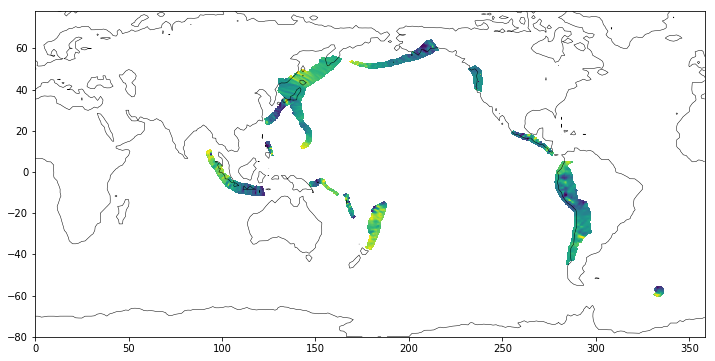

In [22]:
plotslab('strike')

In [23]:
import pandas as pd

xgrid, ygrid = np.meshgrid(x[file], y[file])
xgrid = xgrid.ravel()
ygrid = ygrid.ravel()

selection = np.where(np.logical_not(focal[file]['depth'].mask.ravel()))

xout = xgrid[selection]
yout = ygrid[selection]
depth_out = focal[file]['depth'].data.ravel()[selection]
dip_out = focal[file]['dip'].data.ravel()[selection]
strike_out = focal[file]['strike'].data.ravel()[selection]

xyz = np.vstack([xout, yout, depth_out, strike_out, dip_out]).T

In [24]:
def getUnmaskedRavel(file):
    xgrid, ygrid = np.meshgrid(x[file], y[file])
    xgrid = xgrid.ravel()
    ygrid = ygrid.ravel()

    selection = np.where(np.logical_not(focal[file]['depth'].mask.ravel()))

    xout = xgrid[selection]
    yout = ygrid[selection]
    depth_out = focal[file]['depth'].data.ravel()[selection]
    dip_out = focal[file]['dip'].data.ravel()[selection]
    strike_out = focal[file]['strike'].data.ravel()[selection]

    xyz = np.vstack([xout, yout, depth_out, strike_out, dip_out]).T[::10,:]    
    return xyz

In [25]:
file = files[0]
xyz = getUnmaskedRavel(file)
for file in files:
    newxyz = getUnmaskedRavel(file)
    xyz = np.vstack([xyz, newxyz])

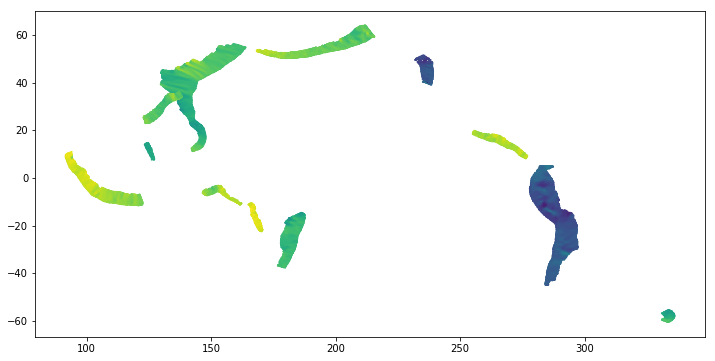

In [27]:
k = 10
plt.figure(figsize=(12,6))
plt.scatter(xyz[::k,0],xyz[::k,1],c=xyz[::k,3],s=1)

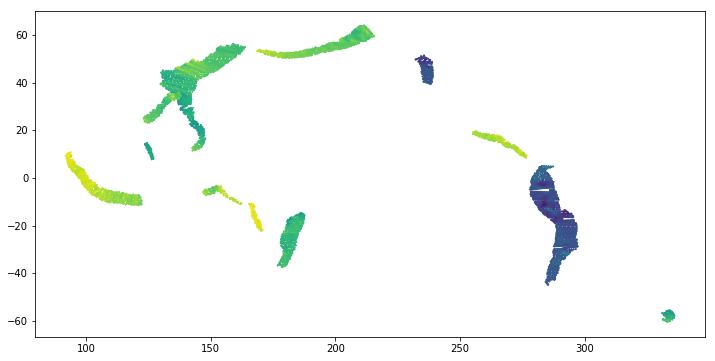

In [28]:
k = 50
plt.figure(figsize=(12,6))
plt.scatter(xyz[::k,0],xyz[::k,1],c=xyz[::k,3],s=1)

In [29]:
np.savetxt('slabs.txt',xyz[::50,:])